In [1]:
import numpy as np
import keras
from keras.layers import Dense, Activation, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import LeakyReLU, Input, Reshape, Conv2DTranspose, UpSampling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import Sequential, Model, load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [6]:
(X_train.shape)

(60000, 28, 28)

In [0]:
adam = Adam(lr=0.0002, beta_1=0.5)

In [8]:
try:
    discriminator = load_model('discriminator.h5')
except:
    discriminator = Sequential()
    discriminator.add(Conv2D(128,(3,3), activation='relu',input_shape=(28,28,1),padding='same'))
    discriminator.add(Dense(1,activation='relu'))
    discriminator.add(Reshape((784,)))
    # discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    # discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    # discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

W0704 13:46:40.819725 139906769266560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 13:46:40.829579 139906769266560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 13:46:40.836718 139906769266560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 13:46:40.939411 139906769266560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0704 13:46:40.949594 139906769266560 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
dense_1 (Dense)              (None, 28, 28, 1)         129       
_________________________________________________________________
reshape_1 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
__________

In [9]:
try:
    generator = load_model('generator.h5')
except:
    generator = Sequential()
    generator.add(Dense(800, input_dim=10))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((5,5,32)))
    generator.add(UpSampling2D((2,2)))
    generator.add(Conv2DTranspose(256,(3,3),activation='relu'))
    generator.add(UpSampling2D((2,2)))
    generator.add(Conv2DTranspose(128,(3,3),activation='relu'))
    generator.add(Conv2DTranspose(1,(3,3),activation='relu'))
    generator.add(Activation('tanh'))
    
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

W0704 13:46:41.053466 139906769266560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 800)               8800      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 800)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 5, 5, 32)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 12, 12, 256)       73984     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 128)       295040    
__________

In [0]:
y_train = np_utils.to_categorical(y_train)

In [11]:
y_train.shape,X_train.shape

((60000, 10), (60000, 28, 28))

In [0]:
X_train = X_train.astype('float64')
X_train /= 255
X_test = X_test.astype('float64')
X_test /= 255

In [0]:
#y_train = y_train.reshape((len(y_train),10))

In [0]:
X_train = X_train.reshape(len(X_train),28,28,1)

In [15]:
y_train.shape,X_train.shape

((60000, 10), (60000, 28, 28, 1))

In [16]:
try:
    gan = load_model('gan.h5')
except:
    discriminator.trainable = False
    # gan input (noise) will be 10-dimensional vectors
    gan_input = Input(shape=(10,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         378977    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 268418    
Total params: 647,395
Trainable params: 378,977
Non-trainable params: 268,418
_________________________________________________________________


In [0]:
def plot_loss(losses):
    d_loss = losses['D']
    g_loss = losses['G']
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [0]:
def plot_generated(figsize=(12, 2)):
    noise = y_train[np.random.randint(0, y_train.shape[0], size=10)]
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(10, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

W0704 13:46:41.929654 139906769266560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



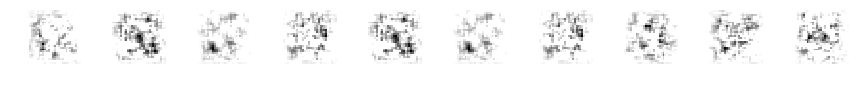

In [19]:
plot_generated()

In [0]:
def train(epoch=1, ploting_ep = 20 , batch_size=128):
    losses = {'D':[],'G':[]}
    batch_count = X_train.shape[0] // batch_size
    for i in range(1,epoch+1):
        for j in range(batch_count):
            # Input for the generator
            noise_input = y_train[j*batch_size:(j+1)*batch_size]

            # getting random images from X_train of size=batch_size 
            # these are the real images that will be fed to the discriminator
            image_batch = X_train[j*batch_size:(j+1)*batch_size]

            # these are the predicted images from the generator
            predictions = generator.predict(noise_input, batch_size=batch_size)
            
            # the discriminator takes in the real images and the generated images
            X = np.concatenate([ image_batch,predictions])
            
            # labels for the discriminator
            y_discriminator = np.zeros(2*batch_size)
            y_discriminator[:batch_size] = 1
            
            # Let's train the discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_discriminator)

            # Let's train the generator
            y_generator = np.ones(batch_size)
            discriminator.trainable = False
            
            g_loss = gan.train_on_batch(noise_input, y_generator)
        losses['D'].append(d_loss)
        losses['G'].append(g_loss)
        print("Epoch :  {0}/{1}  Dicriminator Loss : {2:.2f}  Generator Loss : {3:.2f}".format(i,epoch,d_loss,g_loss))
        if i==1 or i%ploting_ep==0:
            plot_generated()
    plot_loss(losses)
    return losses

Epoch :  1/100  Dicriminator Loss : 0.36  Generator Loss : 1.92


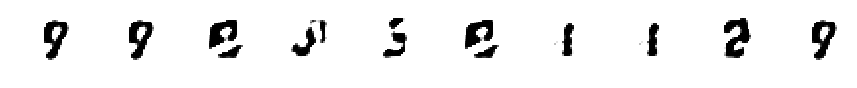

Epoch :  2/100  Dicriminator Loss : 0.61  Generator Loss : 4.47
Epoch :  3/100  Dicriminator Loss : 0.27  Generator Loss : 2.23
Epoch :  4/100  Dicriminator Loss : 0.21  Generator Loss : 1.81
Epoch :  5/100  Dicriminator Loss : 0.38  Generator Loss : 1.69


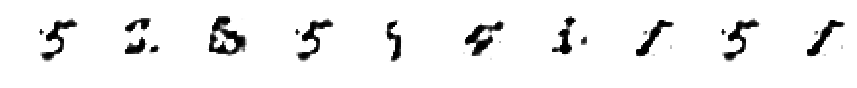

Epoch :  6/100  Dicriminator Loss : 0.28  Generator Loss : 2.59
Epoch :  7/100  Dicriminator Loss : 0.52  Generator Loss : 1.83
Epoch :  8/100  Dicriminator Loss : 0.42  Generator Loss : 1.42
Epoch :  9/100  Dicriminator Loss : 0.40  Generator Loss : 2.00
Epoch :  10/100  Dicriminator Loss : 0.25  Generator Loss : 1.76


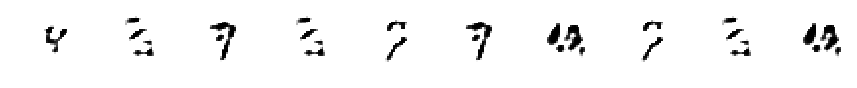

Epoch :  11/100  Dicriminator Loss : 0.33  Generator Loss : 3.49
Epoch :  12/100  Dicriminator Loss : 0.28  Generator Loss : 1.79
Epoch :  13/100  Dicriminator Loss : 0.27  Generator Loss : 1.87
Epoch :  14/100  Dicriminator Loss : 0.28  Generator Loss : 2.17
Epoch :  15/100  Dicriminator Loss : 0.24  Generator Loss : 1.80


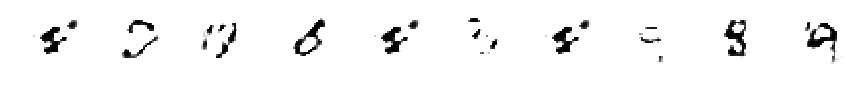

Epoch :  16/100  Dicriminator Loss : 0.31  Generator Loss : 2.69
Epoch :  17/100  Dicriminator Loss : 0.46  Generator Loss : 1.18
Epoch :  18/100  Dicriminator Loss : 0.41  Generator Loss : 1.52
Epoch :  19/100  Dicriminator Loss : 0.30  Generator Loss : 1.65
Epoch :  20/100  Dicriminator Loss : 0.22  Generator Loss : 1.90


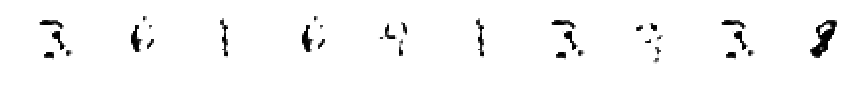

Epoch :  21/100  Dicriminator Loss : 0.16  Generator Loss : 2.31
Epoch :  22/100  Dicriminator Loss : 0.29  Generator Loss : 2.52
Epoch :  23/100  Dicriminator Loss : 0.23  Generator Loss : 1.99
Epoch :  24/100  Dicriminator Loss : 0.31  Generator Loss : 3.05
Epoch :  25/100  Dicriminator Loss : 0.30  Generator Loss : 1.98


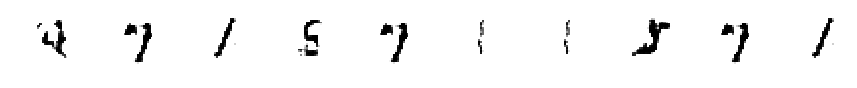

Epoch :  26/100  Dicriminator Loss : 0.27  Generator Loss : 1.76
Epoch :  27/100  Dicriminator Loss : 0.29  Generator Loss : 4.14
Epoch :  28/100  Dicriminator Loss : 0.20  Generator Loss : 2.75
Epoch :  29/100  Dicriminator Loss : 0.41  Generator Loss : 2.57
Epoch :  30/100  Dicriminator Loss : 0.24  Generator Loss : 2.07


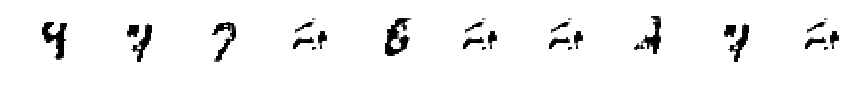

Epoch :  31/100  Dicriminator Loss : 0.09  Generator Loss : 3.58
Epoch :  32/100  Dicriminator Loss : 0.12  Generator Loss : 3.86
Epoch :  33/100  Dicriminator Loss : 0.19  Generator Loss : 2.61
Epoch :  34/100  Dicriminator Loss : 0.09  Generator Loss : 3.12
Epoch :  35/100  Dicriminator Loss : 0.10  Generator Loss : 3.58


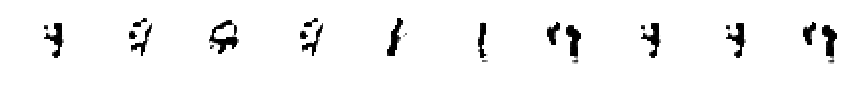

Epoch :  36/100  Dicriminator Loss : 0.24  Generator Loss : 4.67
Epoch :  37/100  Dicriminator Loss : 0.19  Generator Loss : 1.59
Epoch :  38/100  Dicriminator Loss : 0.22  Generator Loss : 3.63
Epoch :  39/100  Dicriminator Loss : 0.12  Generator Loss : 2.75
Epoch :  40/100  Dicriminator Loss : 0.18  Generator Loss : 3.58


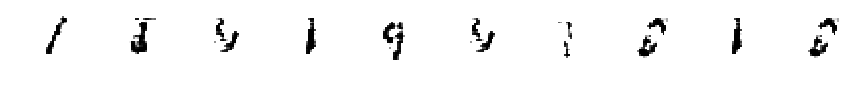

Epoch :  41/100  Dicriminator Loss : 0.18  Generator Loss : 2.64
Epoch :  42/100  Dicriminator Loss : 0.24  Generator Loss : 2.35
Epoch :  43/100  Dicriminator Loss : 0.17  Generator Loss : 4.94
Epoch :  44/100  Dicriminator Loss : 0.13  Generator Loss : 3.05
Epoch :  45/100  Dicriminator Loss : 0.13  Generator Loss : 5.69


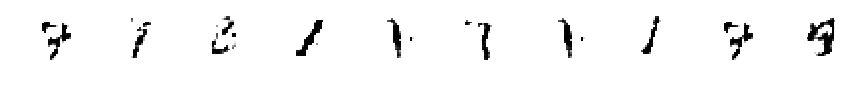

Epoch :  46/100  Dicriminator Loss : 0.12  Generator Loss : 3.35
Epoch :  47/100  Dicriminator Loss : 0.19  Generator Loss : 2.97
Epoch :  48/100  Dicriminator Loss : 0.06  Generator Loss : 3.59
Epoch :  49/100  Dicriminator Loss : 0.08  Generator Loss : 3.09
Epoch :  50/100  Dicriminator Loss : 0.11  Generator Loss : 3.21


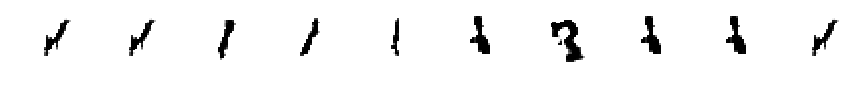

Epoch :  51/100  Dicriminator Loss : 0.08  Generator Loss : 3.78
Epoch :  52/100  Dicriminator Loss : 0.11  Generator Loss : 3.00
Epoch :  53/100  Dicriminator Loss : 0.14  Generator Loss : 3.59
Epoch :  54/100  Dicriminator Loss : 0.02  Generator Loss : 3.76
Epoch :  55/100  Dicriminator Loss : 0.00  Generator Loss : 6.06


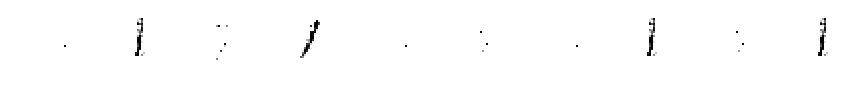

Epoch :  56/100  Dicriminator Loss : 0.26  Generator Loss : 4.42
Epoch :  57/100  Dicriminator Loss : 0.15  Generator Loss : 2.73
Epoch :  58/100  Dicriminator Loss : 0.18  Generator Loss : 2.85
Epoch :  59/100  Dicriminator Loss : 0.19  Generator Loss : 2.47
Epoch :  60/100  Dicriminator Loss : 0.20  Generator Loss : 2.52


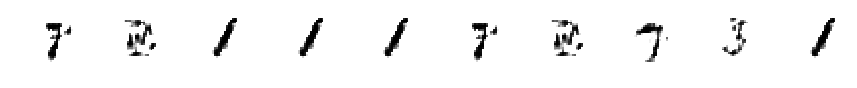

Epoch :  61/100  Dicriminator Loss : 0.26  Generator Loss : 2.05
Epoch :  62/100  Dicriminator Loss : 0.12  Generator Loss : 3.41
Epoch :  63/100  Dicriminator Loss : 0.20  Generator Loss : 2.35
Epoch :  64/100  Dicriminator Loss : 0.20  Generator Loss : 2.27
Epoch :  65/100  Dicriminator Loss : 0.13  Generator Loss : 2.51


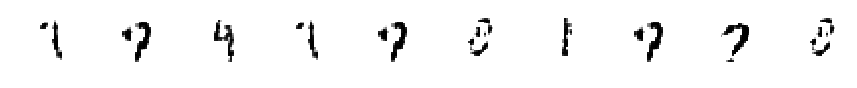

Epoch :  66/100  Dicriminator Loss : 0.06  Generator Loss : 4.22
Epoch :  67/100  Dicriminator Loss : 0.14  Generator Loss : 3.46
Epoch :  68/100  Dicriminator Loss : 0.10  Generator Loss : 3.68
Epoch :  69/100  Dicriminator Loss : 0.07  Generator Loss : 4.85
Epoch :  70/100  Dicriminator Loss : 0.14  Generator Loss : 3.05


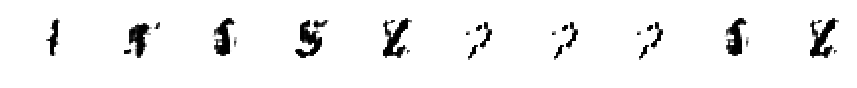

Epoch :  71/100  Dicriminator Loss : 0.23  Generator Loss : 1.87
Epoch :  72/100  Dicriminator Loss : 0.08  Generator Loss : 3.61
Epoch :  73/100  Dicriminator Loss : 0.10  Generator Loss : 3.28
Epoch :  74/100  Dicriminator Loss : 0.08  Generator Loss : 3.63
Epoch :  75/100  Dicriminator Loss : 0.09  Generator Loss : 2.87


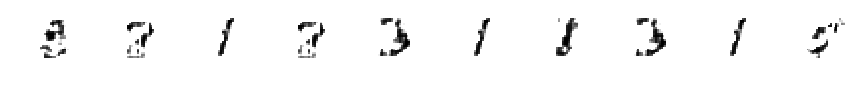

Epoch :  76/100  Dicriminator Loss : 0.15  Generator Loss : 2.24
Epoch :  77/100  Dicriminator Loss : 0.11  Generator Loss : 2.95
Epoch :  78/100  Dicriminator Loss : 0.13  Generator Loss : 4.39
Epoch :  79/100  Dicriminator Loss : 0.09  Generator Loss : 3.47
Epoch :  80/100  Dicriminator Loss : 0.05  Generator Loss : 4.02


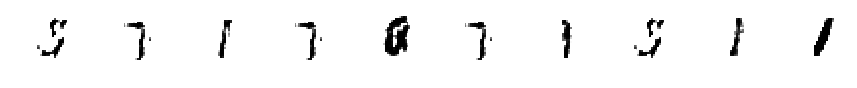

Epoch :  81/100  Dicriminator Loss : 0.15  Generator Loss : 3.42
Epoch :  82/100  Dicriminator Loss : 0.09  Generator Loss : 2.90
Epoch :  83/100  Dicriminator Loss : 0.11  Generator Loss : 3.53
Epoch :  84/100  Dicriminator Loss : 0.05  Generator Loss : 3.52
Epoch :  85/100  Dicriminator Loss : 0.12  Generator Loss : 3.04


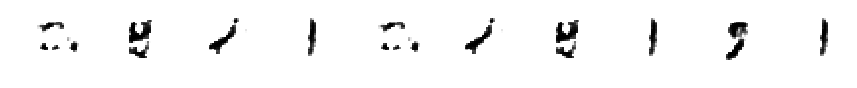

Epoch :  86/100  Dicriminator Loss : 0.07  Generator Loss : 3.07
Epoch :  87/100  Dicriminator Loss : 0.07  Generator Loss : 3.29
Epoch :  88/100  Dicriminator Loss : 0.11  Generator Loss : 3.44
Epoch :  89/100  Dicriminator Loss : 0.15  Generator Loss : 2.84
Epoch :  90/100  Dicriminator Loss : 0.09  Generator Loss : 3.11


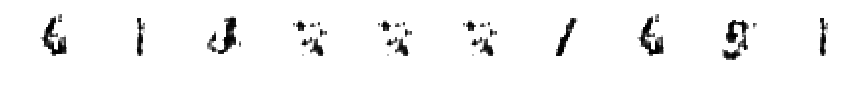

Epoch :  91/100  Dicriminator Loss : 0.07  Generator Loss : 3.32
Epoch :  92/100  Dicriminator Loss : 0.05  Generator Loss : 3.81
Epoch :  93/100  Dicriminator Loss : 0.05  Generator Loss : 3.39
Epoch :  94/100  Dicriminator Loss : 0.03  Generator Loss : 3.96
Epoch :  95/100  Dicriminator Loss : 0.10  Generator Loss : 3.00


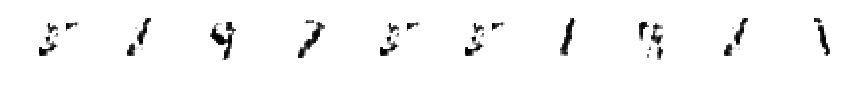

Epoch :  96/100  Dicriminator Loss : 0.23  Generator Loss : 2.32
Epoch :  97/100  Dicriminator Loss : 0.13  Generator Loss : 4.31
Epoch :  98/100  Dicriminator Loss : 0.05  Generator Loss : 3.62
Epoch :  99/100  Dicriminator Loss : 0.10  Generator Loss : 4.22
Epoch :  100/100  Dicriminator Loss : 0.13  Generator Loss : 3.30


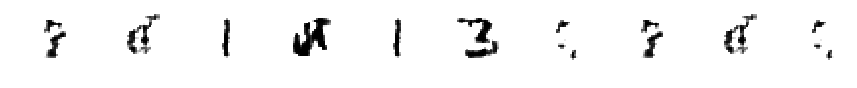

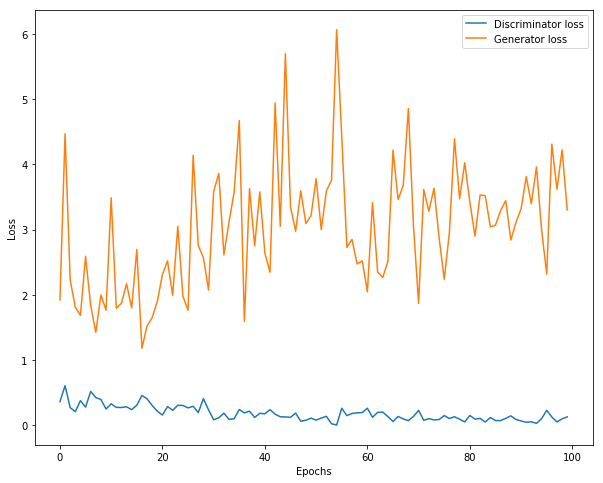

CPU times: user 48min 18s, sys: 23min 15s, total: 1h 11min 34s
Wall time: 1h 25min 56s


In [22]:
%%time
losses = train(100,5)

In [0]:
gan.save('gan.h5')
generator.save('generator.h5')
discriminator.save('discriminator.h5')